# Simulating Everything with Different Models
Use this notebook to simulate everything from (1) creating the initial motor imagery and error models, to (2) simulating adaptation for these, and (3) visualizing the performance for different adaptation conditions.

This was made primarily to allow us to easily ask "how would the subjects perform if we had used an SVM, or some other type of model instead?". One concern is that subject performance has been so low because the models being used to classify motor imagery could be overfit to the motor screening data.

Nile Wilson, 2019.03.04

In [1]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC, LinearSVC
from sklearn.metrics import confusion_matrix
from sklearn.neural_network import MLPClassifier
from matplotlib import pyplot as plt
from scipy.fftpack import fft, ifft
from scipy import signal
from mne.filter import filter_data

import scipy.signal as scisig
import numpy as np
import pandas as pd
import datetime
import pickle
import glob
import csv
import mne
import os

# Set Your Variables
Define which subject's data you are going to use to simulate performance (be sure to make sure the subject_group and session_number are correct)

In [2]:
subjID = 'e2cbc4'
subject_group = 1
session_number = 1
EEGdevice = 8

# model_type will be used to name/organize all files associated with whatever you run here
model_type = 'test'

Create all the directories things might be saved in

In [3]:
try:
    os.makedirs('Models/' + subjID + '/' + model_type + '/Session1')
    os.makedirs('Models/' + subjID + '/' + model_type + '/Session2')
    os.makedirs('Models/' + subjID + '/' + model_type + '/Session3')
    os.makedirs('Figures/' + subjID + '/' + model_type)
except:
    print('Directories already exist')

Directories already exist


# PART 1: Create the Initial Models
This section allows us to play around with the initial motor imagery and error classifier models.

### Create the error classifier
This should take less than 2 minutes to run. Check Models/subjID/Session1 to see if the error model and the data file are generated.

Once they are generated, you may have to stop and restart the kernel, and run the notebook but skip the cell below.

In [7]:
arg_EEGdevice = str(EEGdevice)

In [8]:
#!python Create_Error_classifier.py -s $subjID -e $arg_EEGdevice -f n -m $model_type

The above cell for some reason doesn't allow the notebook's kernel to move on after it has finished, so just call it manually in your Anaconda prompt using the below lines (replace the variables with their values):

In [10]:
print('python Create_Error_classifier.py -s ' + subjID + ' -e ' + arg_EEGdevice + ' -f n -m ' + model_type)

python Create_Error_classifier.py -s e2cbc4 -e 8 -f n -m test


### Create the motor imagery classifier

#### Function Definitions

In [11]:
def LoadEEGData(filename, EEGdevice):
    """ This function converts a single .easy file (from NIC2) to an easy-to-use dataframe.
    Uses both the .easy file and .info file (containing metadata)
    
    ---- Input ----
    filename: string containing the .easy filepath
    
    ---- Output ----
    df: dataframe containing all the EEG, accelerometer, and event marker data
    fs: sampling rate for the EEG data (Hz)
    fs_accel: sampling rate for the accelerometer data (Hz)
    
    """
    if EEGdevice == 7:
        x = 1
    elif EEGdevice == 8:
        # Read in the .easy file
        df = pd.read_csv(filename, delimiter='\t', header=None)

        # Get metadata from the .info file
        fname = filename[:-5] + '.info'
        with open(fname) as f:
            content = f.readlines()
        content = [x.strip() for x in content]

        # Get the channel names
        channel_info = [x for x in content if 'Channel ' in x]
        channel_names = []
        for ch in range(len(channel_info)):
            channel_names.append(channel_info[ch].split(': ')[1])

        channel_names.append('X')
        channel_names.append('Y')
        channel_names.append('Z')
        channel_names.append('STI 014')
        channel_names.append('DateTime')

        # Get sampling rates
        sampling_rates = [x for x in content if 'sampling rate: ' in x]
        fs_all = []
        for freq in range(len(sampling_rates)):
            tmp = sampling_rates[freq].split(': ')[1].split(' ')[0]
            if tmp in ['N/A']:
                print('Skipping N/A')
            else:
                fs_all.append(float(sampling_rates[freq].split(': ')[1].split(' ')[0]))

        # Store sampling rates
        fs = fs_all[0]
        fs_accel = fs_all[1]

        # Assign the column names
        df.columns = channel_names
    
    # Return dataframe and sampling rates
    return df, fs, fs_accel

def LoadBehavioralData(filename_behavioral):
    """
    This function loads behavioral data for the motor screening task and formats it to use in this script
    """
    behavioralData = pd.read_csv(filename_behavioral, ',')
    behavioralData = behavioralData.transpose()
    behavioralHeader = behavioralData.iloc[0]
    behavioralData = behavioralData.iloc[2:]
    behavioralData.columns = behavioralHeader
    
    return behavioralData

def SyncTriggerPulses(EEGdata, EEGdevice, fs, behavioralData):
    """
    This function returns the indices for events of interest
    """
    
    if EEGdevice == 7:
        print('Put code here')
    elif EEGdevice == 8:
        # Store where the values in trigger are equal to 8 (the audio trigger input channel number)
        index_trigger = np.where(EEGdata['STI 014']!=0)
        index_trigger = index_trigger[0]
        
        # Check number of trials
        num_of_trials = behavioralData.shape[0]
        if num_of_trials > len(index_trigger):
            num_of_trials = num_of_trials - 1
            num_trials_removed = 1
        else:
            num_trials_removed = 0
        
        trialLength = int(behavioralData['trialLength'][1])

        # Get trial timing
        t_trial_start = list()
        t_trial_end = list()

        # Creating lists of all trigger start and end locations
        for i in range(0,num_of_trials):
            t_trial_start.append(index_trigger[i])
            t_trial_end.append(index_trigger[i] + int(trialLength*fs))

        # Save rest period epochs as well as trials for comparison
        t_rest_start = list()
        t_rest_end = list()

        for i in range(num_of_trials-1):
            t_rest_start.append(t_trial_end[i])
            t_rest_end.append(t_trial_start[i+1])
    
    return num_of_trials, t_trial_start, t_trial_end, t_rest_start, t_rest_end

def EpochData(EEGdata, t_trial_start, t_trial_end):
    """
    This function epochs the data
    """
    
    if EEGdevice == 7:
        channels = EEGdata.columns[1:8]
    elif EEGdevice == 8:
        channels = EEGdata.columns[0:8]
    
    epochs = []
    epochs_norm = []

    for trial in range(0,len(t_trial_start)):
        t_start = t_trial_start[trial]
        t_end = t_trial_end[trial]

        # Baseline
        if trial == 0:
            tb_start = t_trial_start[trial] - np.round(1.5*fs)
            tb_end = t_trial_start[trial]
        else:
            tb_start = t_trial_end[trial-1]
            tb_end = t_trial_start[trial]
            
        baseline = EEGdata.loc[tb_start:tb_end][channels]
        
        # Store epoch
        tmp = (EEGdata.loc[t_start:t_end][channels] - np.mean(baseline))/np.std(baseline)
        epochs_norm.append(tmp)
        epochs.append(EEGdata.loc[t_start:t_end][channels])
    
    return epochs, epochs_norm

def CutEpochs(epochs, fs, trial_type):
    epochs_cut = []
    trial_type_cut = list()

    num_of_epochs = len(epochs)
    full_epoch_length = np.shape(epochs[0])[0]
    cut_epoch_length = int(1.750*fs)

    sliding_window_starts = np.floor(np.linspace(1*fs, full_epoch_length - cut_epoch_length, 10))

    # For each epoch
    for epochOfInt in range(0,num_of_epochs):
        # Reset the index within each epoch temporarily
        reset_index = epochs[epochOfInt].reset_index(drop=True)

        # Sliding window of 750 ms
        for new_start in sliding_window_starts:
            tmp = reset_index.loc[new_start:new_start+cut_epoch_length]
            epochs_cut.append(tmp)
            trial_type_cut.append(trial_type[epochOfInt])
    
    num_of_trials_cut = len(trial_type_cut)
    
    return epochs_cut, trial_type_cut, num_of_trials_cut

def OrganizeTrials(behavioralData):
    """
    Organizes trials
    """
    
    # Create lists for each trial type
    trialL = list()
    trialR = list()
    i = 0

    for letter in behavioralData['trialType']:
        if letter == 'L':
            trialL.append(i)
        elif letter == 'R':
            trialR.append(i)
        i += 1
    
    # Create a single list that includes which trial is which (L = 0, R = 1)
    trial_type = list()
    i = 0

    for letter in behavioralData['trialType']:
        if letter == 'L':
            trial_type.append(0)
        elif letter == 'R':
            trial_type.append(1)
        i += 1
    
    print('np.shape(trial_type): ' + str(np.shape(trial_type)))

    return trial_type, trialL, trialR

def ExtractFeatures(epochs, num_of_trials, channelsToUse, ds_factor):
    """
    Extract signal features of interest
    """
    
    # Get the summed delta power for each trial
    alpha_power = dict.fromkeys(channelsToUse)
    beta_power = dict.fromkeys(channelsToUse)
    ds_f = ds_factor # downsampling factor

    for chanOfInt in channelsToUse:
        tmp_alpha = list()
        tmp_beta = list()

        for trial in range(0, num_of_trials):
            f, Pxx_den = signal.welch(signal.decimate(epochs[trial][chanOfInt],ds_f), fs/ds_f, scaling='spectrum')
            alpha_idx = np.where(np.logical_and(np.round(f) > 8, np.round(f) <= 12))
            tmp_alpha.append(np.sum(Pxx_den[alpha_idx]))

            beta_idx = np.where(np.logical_and(np.round(f) > 13, np.round(f) <= 30))
            tmp_beta.append(np.sum(Pxx_den[beta_idx]))

        alpha_power[chanOfInt] = tmp_alpha
        beta_power[chanOfInt] = tmp_beta
    
    return alpha_power, beta_power

def SaveDecoderAndData(clf, X, X_not_scaled, y, subjID, session_number, model_type):
    """
    Save the decoder and the data it was trained/tested on
    """
    time_to_save = datetime.datetime.now().isoformat()
    time_to_save = time_to_save.replace('T','-')
    time_to_save = time_to_save.replace(':','-')
    
    model = clf
    model_file = 'Models/' + subjID + '/' + model_type + '/Session' + str(session_number) + '/' + subjID + '_MI_classifier_' + time_to_save[:19] + '.sav'
    pickle.dump(model, open(model_file, 'wb'))
    
    filepath_export_data = 'Models/' + subjID + '/' + model_type + '/Session' + str(session_number) + '/' + subjID + '_data_for_MI_classifier_' + time_to_save[:19] + '.npz'
    np.savez_compressed(filepath_export_data, subjID=subjID, X=X, X_not_scaled=X_not_scaled, y=y)

#### Run code

**Edit this one to change what the initial decoder is like!**

In [12]:
def TrainDecoder(X, y):
    """
    Trains the decoder on ALL the data (does not split into test and train because this is all train)
    """
    # preprocess dataset, split into training and test part
    args = np.arange(len(X))
    np.random.shuffle(args)
    X = [X[i] for i in args]
    y = [y[i] for i in args]
    X_not_scaled = X
    X = StandardScaler().fit_transform(X)

    # Resample to account for imbalance
    method = SMOTE(kind='regular')
    X_balanced, y_balanced = method.fit_sample(X, y)

    # Determine model parameters
    activations = ['relu','tanh']
    alphas = np.logspace(-6, 3, 10)
    solvers = ['lbfgs','sgd']
    hyper_params = {"activation":activations, "alpha":alphas, "solver":solvers}
    grid = GridSearchCV(MLPClassifier(learning_rate='constant', random_state=1), param_grid=hyper_params, cv=KFold(n_splits=5), verbose=True)
    grid.fit(X_balanced, y_balanced)

    # Fit the model
    clf = grid.best_estimator_
    clf.fit(X_balanced,y_balanced)

    """
    # Determine model parameters
    activations = ['relu','tanh']
    alphas = np.logspace(-6, 3, 10)
    solvers = ['lbfgs','sgd']
    hyper_params = {"activation":activations, "alpha":alphas, "solver":solvers}
    grid = GridSearchCV(MLPClassifier(learning_rate='constant', random_state=1), param_grid=hyper_params, cv=KFold(n_splits=5), verbose=True)
    grid.fit(X, y)

    # Fit the model
    clf = grid.best_estimator_
    clf.fit(X,y)
    """
    
    return clf, X, X_not_scaled, y

Run

In [13]:
# Automatically find the most recent files
eeg_files = glob.glob('SaveData/' + subjID + '/Session' + str(session_number) + '/*' + subjID + '_Motor*.easy')
filename_eeg = eeg_files[-1] # load the most recent eeg file
print(filename_eeg)

behav_files = glob.glob('SaveData/' + subjID + '/Session' + str(session_number) + '/' + subjID + '_Motor_Screening_*.csv')
filename_behavioral = behav_files[-1] # load the most recent behavioral file
print(filename_behavioral)

SaveData/e2cbc4/Session1\20190301131945_e2cbc4_Motor_Screening.easy
SaveData/e2cbc4/Session1\e2cbc4_Motor_Screening_R1.csv


In [14]:
# Load EEG data
EEGdata, fs, fs_accel = LoadEEGData(filename_eeg, EEGdevice)

# Load behavioral data
behavioralData = LoadBehavioralData(filename_behavioral)

# Sync up trigger pulses
num_of_trials, t_trial_start, t_trial_end, t_rest_start, t_rest_end = SyncTriggerPulses(EEGdata, EEGdevice, fs, behavioralData)

# Filter the data
if EEGdevice == 7:
    channels = EEGdata.columns[1:8]
elif EEGdevice == 8:
    channels = EEGdata.columns[0:8]
EEGdata_filt = EEGdata.copy()
eeg_data = EEGdata[channels].values * 1.0 # multiply by 1.0 to convert int to float
filtered = filter_data(eeg_data.T, sfreq=fs, l_freq=1, h_freq=40)
EEGdata_filt[channels] = filtered.T

# Epoch the data
epochs, epochs_norm = EpochData(EEGdata_filt, t_trial_start, t_trial_end)

# Organize trial types
trial_type, trialL, trialR = OrganizeTrials(behavioralData)

# Cut epochs
epochs_cut, trial_type_cut, num_of_trials_cut = CutEpochs(epochs_norm, fs, trial_type)

# Get signal features
alpha_power, beta_power = ExtractFeatures(epochs_cut, num_of_trials_cut, ['C3','C4'], 1)
motor_features = [alpha_power['C3'], alpha_power['C4'], beta_power['C3'], beta_power['C4']]
motor_features = np.transpose(motor_features)

# Train model
print(np.shape(motor_features))
print(np.shape(trial_type_cut))
print(num_of_trials)
clf, X, X_not_scaled, y = TrainDecoder(motor_features, trial_type_cut)

# Save decoder and data it was trained/tested on
SaveDecoderAndData(clf, X, X_not_scaled, y, subjID, session_number, model_type)

Skipping N/A
Setting up band-pass filter from 1 - 40 Hz
l_trans_bandwidth chosen to be 1.0 Hz
h_trans_bandwidth chosen to be 10.0 Hz
Filter length of 1651 samples (3.302 sec) selected
np.shape(trial_type): (100,)


C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]
C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\signaltools.py:3463: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return y[sl]


(990, 4)
(990,)
99
Fitting 5 folds for each of 40 candidates, totalling 200 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:562: ConvergenceWarning: Stochastic O

# PART 2: Simulate Adaptation
This section borrows code from `Adapt_MI_Decoder_Loop.ipnyb` but changes some of the paths to prevent overlap with the actual experimental data.

If you've already run the below cell with the current subject and session number, skip it (otherwise the kernel will seem busy forever).

In [15]:
arg_group = str(subject_group)
arg_session = str(session_number)
arg_EEGdevice = str(EEGdevice)

In [16]:
#!python Adapt_MI_Decoder_Loop.py -s $subjID -g $arg_group -n $arg_session -e $arg_EEGdevice -m $model_type

The above cell for some reason doesn't allow `Adapt_MI_Decoder_Loop.py` to finish (get's stuck on run 5), so just call it manually in your Anaconda prompt using the below lines (replace the variables with their values):

`python Adapt_MI_Decoder_Loop.py -s $subjID -g $arg_group -n $arg_session -e $arg_EEGdevice -m $model_type`

In [17]:
print('python Adapt_MI_Decoder_Loop.py -s ' + subjID + ' -g ' + arg_group + ' -n ' + arg_session + ' -e ' + arg_EEGdevice + ' -m ' + model_type)

python Adapt_MI_Decoder_Loop.py -s e2cbc4 -g 1 -n 1 -e 8 -m test


# Part 3: Evaluate Performance
This section outputs the plots that allow us to visualize all simulated performance.

In [21]:
# Load latest model and its associated data
BCI_files = glob.glob('SaveData/' + subjID + '/Session' + str(session_number) + '/*' + subjID + '_BCI.easy')
num_of_runs = len(BCI_files)

In [22]:
# Check that this is correct
print('Detected number of BCI runs: ' + str(num_of_runs))

Detected number of BCI runs: 5


### Function Definitions
Functions for working with the BCI data

In [32]:
def FindBCIFiles(subjID, run_number, session_number, model_type):
    """
    Returns the file names for the BCI run of choice
    """
    # Load latest model and its associated data
    BCI_files = glob.glob('SaveData/' + subjID + '/Session' + str(session_number) + '/*' + subjID + '_BCI.easy')
    
    # Throw exception if model number is outside range of existing models
    if run_number-1 > len(BCI_files):
        raise ValueError('Please select a valid run number')
    
    filename_eeg = BCI_files[run_number-1]
    print('Selecting BCI EEG file: ' + filename_eeg)

    behavioral_files = glob.glob('SaveData/' + subjID + '/Session' + str(session_number) + '/BCI_' + subjID + '*.csv')
    filename_behavioral = behavioral_files[run_number-1]
    print('Selecting BCI behavioral file: ' + filename_behavioral)
    
    return filename_eeg, filename_behavioral

In [24]:
def LoadEEGData(filename, EEGdevice):
    """ This function converts a single .easy file (from NIC2) to an easy-to-use dataframe.
    Uses both the .easy file and .info file (containing metadata)
    
    ---- Input ----
    filename: string containing the .easy filepath
    
    ---- Output ----
    df: dataframe containing all the EEG, accelerometer, and event marker data
    fs: sampling rate for the EEG data (Hz)
    fs_accel: sampling rate for the accelerometer data (Hz)
    
    """
    if EEGdevice == 7:
        x = 1
    elif EEGdevice == 8:
        # Read in the .easy file
        df = pd.read_csv(filename, delimiter='\t', header=None)

        # Get metadata from the .info file
        fname = filename[:-5] + '.info'
        with open(fname) as f:
            content = f.readlines()
        content = [x.strip() for x in content]

        # Get the channel names
        channel_info = [x for x in content if 'Channel ' in x]
        channel_names = []
        for ch in range(len(channel_info)):
            channel_names.append(channel_info[ch].split(': ')[1])

        channel_names.append('X')
        channel_names.append('Y')
        channel_names.append('Z')
        channel_names.append('STI 014')
        channel_names.append('DateTime')

        # Get sampling rates
        sampling_rates = [x for x in content if 'sampling rate: ' in x]
        fs_all = []
        for freq in range(len(sampling_rates)):
            tmp = sampling_rates[freq].split(': ')[1].split(' ')[0]
            if tmp in ['N/A']:
                print('Skipping N/A')
            else:
                fs_all.append(float(sampling_rates[freq].split(': ')[1].split(' ')[0]))

        # Store sampling rates
        fs = fs_all[0]
        fs_accel = fs_all[1]

        # Assign the column names
        df.columns = channel_names
    
    # Return dataframe and sampling rates
    return df, fs, fs_accel

In [25]:
def LoadBehavioralDataBCI(filename_behavioral):
    """
    This function loads behavioral data for the motor screening task and formats it to use in this script
    """
    behavioralData = pd.read_csv(filename_behavioral, ',')
    
    return behavioralData

In [26]:
def SyncTriggerPulsesBCI(EEGdata, EEGdevice, fs, behavioralData):
    """
    This function returns the indices for events of interest
    """
    
    if EEGdevice == 7:
        print('Put code here')
    elif EEGdevice == 8:
        # Store where the values in trigger are equal to 8 (the audio trigger input channel number)
        index_trigger = np.where(EEGdata['STI 014']!=0)
        index_trigger = index_trigger[0]

        # Number of trials is greater than number of total pulses sent
        # 999 when the task ends
        move_left_starts = np.where(EEGdata['STI 014'] == 1)[0]
        move_right_starts = np.where(EEGdata['STI 014'] == 2)[0]
        rest_starts = np.where(EEGdata['STI 014'] == 3)[0]
        rest_ends = np.where(EEGdata['STI 014'] == 4)[0]
        
        # If the number of rest_starts and rest_ends don't match, drop the extra one
        # there should, by default, only be 12 starts and 12 ends

        if len(rest_ends) > len(rest_starts):
            if rest_ends[0] < rest_starts[0]:
                rest_ends = rest_ends[1:]
        elif len(rest_ends) < len(rest_starts):
            if rest_ends[0] > rest_starts[0]:
                rest_starts = rest_starts[1:]
        
        move_starts = np.sort(np.concatenate((move_left_starts,move_right_starts),0))
        total_movements = len(move_starts)

        # exclude movements that occur without defined baseline (if you need to get rid of first rest)
        hasBaseline = list()
        for movement in range(0,len(move_starts)):
            hasBaseline.append(True in (rest_starts < move_starts[movement]))

        np.where(hasBaseline)
        move_starts = move_starts[np.where(hasBaseline)]

        # exclude the move lefts and move rights that were thrown out in move_starts
        for movement in range(0,total_movements):
            if hasBaseline[movement] is False:
                # for the left movements
                idx_left = np.where(move_left_starts == move_starts[movement])
                idx_left = np.asarray(idx_left)
                idx_right = np.where(move_right_starts == move_starts[movement])
                idx_right = np.asarray(idx_right)

                if idx_left.size > 0:
                    move_left_starts = np.delete(move_left_starts, idx_left)
                if idx_right.size > 0:
                    move_right_starts = np.delete(move_right_starts, idx_right)
                
        num_of_trials = len(rest_starts)
        num_of_movements = len(move_left_starts) + len(move_right_starts)
    
    return num_of_trials, num_of_movements, move_starts, hasBaseline, rest_starts, rest_ends

In [27]:
def EpochBCIData(EEGdata, fs, move_starts, rest_starts, rest_ends):
    """
    This function epochs the data
    """
    
    if EEGdevice == 7:
        channels = EEGdata.columns[1:8]
    elif EEGdevice == 8:
        channels = EEGdata.columns[0:8]

    epochs = []
    epochs_norm = []

    for movement in range(0,len(move_starts)):
        # Data for this movement
        t_start = move_starts[movement] - np.round(2.00*fs)
        t_end = move_starts[movement] - np.round(0.250*fs)

        # Baseline
        restOfInt = np.max(np.where(rest_starts < move_starts[movement]))
        tb_start = rest_starts[restOfInt]
        tb_end = rest_ends[restOfInt]

        # Note, baseline is filtered before it is used in the live script
        baseline_pre_filt = np.asarray(EEGdata.loc[tb_start:tb_end][channels]) * 1.0
        baseline_filt = filter_data(baseline_pre_filt.T, sfreq=fs, l_freq=7, h_freq=31, verbose='ERROR')
        baseline = baseline_filt.T

        # Filter per epoch, like you would in real-time
        pre_filt = np.asarray(EEGdata.loc[t_start:t_end][channels]) * 1.0
        filtered = filter_data(pre_filt.T, sfreq=fs, l_freq=7, h_freq=31, verbose='ERROR')
        epoch = pd.DataFrame(filtered.T)
        epoch.columns = EEGdata.columns[0:8]

        # Store epoch
        tmp = (epoch - np.mean(baseline))/np.std(baseline)
        tmp = pd.DataFrame(tmp)
        tmp.columns = EEGdata.columns[0:8]

        epochs_norm.append(tmp)
        epochs.append(epoch)

    return epochs, epochs_norm

In [28]:
def OrganizeTrials(behavioralData, hasBaseline):
    """
    Organizes trials
    """
    
    # When the target is to the left
    trialL = np.where(behavioralData['target_x'] < 1000)
    
    # When target was to the right
    trialR = np.where(behavioralData['target_x'] > 1000)
    
    # Create a single list that includes which movement is which (L = 0, R = 1)
    trial_type = np.zeros([1,len(behavioralData['score'])])
    trial_type[0][trialL] = 0
    trial_type[0][trialR] = 1

    trial_type = np.round(trial_type[0])
    
    # Remove trials if no baseline
    for movement in range(0,len(hasBaseline)):
        if hasBaseline[movement] is False:
            trial_type = np.delete(trial_type, movement)
            
    return trial_type

In [29]:
def ExtractFeaturesBCI(epochs, num_of_movements, channelsToUse, ds_factor):
    """
    Extract signal features of interest
    """
    
    # Get the summed delta power for each trial
    alpha_power = dict.fromkeys(channelsToUse)
    beta_power = dict.fromkeys(channelsToUse)
    ds_f = ds_factor # downsampling factor

    for chanOfInt in channelsToUse:
        tmp_alpha = list()
        tmp_beta = list()

        for movement in range(0, num_of_movements):
            f, Pxx_den = signal.welch(signal.decimate(epochs[movement][chanOfInt],ds_f), fs/ds_f, scaling='spectrum')
            alpha_idx = np.where(np.logical_and(np.round(f) > 8, np.round(f) <= 12))
            tmp_alpha.append(np.sum(Pxx_den[alpha_idx]))

            beta_idx = np.where(np.logical_and(np.round(f) > 13, np.round(f) <= 30))
            tmp_beta.append(np.sum(Pxx_den[beta_idx]))

        alpha_power[chanOfInt] = tmp_alpha
        beta_power[chanOfInt] = tmp_beta
    
    return alpha_power, beta_power

In [30]:
def LoadModel_MI(subjID, model_type, run_number=0, session_number=1, adaptationType='CS'):
    """
    This function loads the most recent motor imagery classifier
    for this subject by default. Current run minus 1.
    
    You may also select which number model (from original to most recent)
    by using a value from 0 (original) to 4 (most recent)
    """
    runOfInt = run_number
    run_number = runOfInt - 1
    # Load latest model and its associated data
    if runOfInt == 1:
        models = glob.glob('Models/' + subjID + '/' + model_type + '/Session' + str(session_number) + '/' + subjID + '_MI_classifier_*')
        models_data_list = glob.glob('Models/' + subjID + '/' + model_type + '/Session' + str(session_number) + '/' + subjID + '_data_for_MI_classifier_*')
    else:
        if adaptationType == 'CS' or adaptationType == 'None':
            models = glob.glob('Models/' + subjID + '/' + model_type + '/Session' + str(session_number) + '/' + subjID + '_MI_classifier_*')
            models_data_list = glob.glob('Models/' + subjID + '/' + model_type + '/Session' + str(session_number) + '/' + subjID + '_data_for_MI_classifier_*')
        elif adaptationType == 'TL':
            models = glob.glob('Models/' + subjID + '/' + model_type + '/Session' + str(session_number) + '/' + subjID + '_MI_classifier_TL_*')
            models_data_list = glob.glob('Models/' + subjID + '/' + model_type + '/Session' + str(session_number) + '/' + subjID + '_data_for_MI_classifier_TL_*')
    
    # Throw exception if model number is outside range of existing models
    if run_number > len(models):
        raise ValueError('Please select a valid model number')
    if adaptationType == 'TL':
        run_number = run_number -1
    model_file = models[run_number] # load the most recent model
    print('Selecting model: ' + model_file)
    clf = pickle.load(open(model_file, 'rb'))

    models_data = models_data_list[run_number] # load the most recent model
    MI_data = np.load(models_data)
    X_loaded = MI_data['X_not_scaled']
    y_loaded = MI_data['y']
    
    return clf, X_loaded, y_loaded

## Code to Run

Run in a loop

In [33]:
orig_scores = list()
sim_scores = list()
sim_TL_scores = list()
X_orig_all = dict()
y_orig_all = dict()
X_sim_all = dict()
y_sim_all = dict()
X_sim_TL_all = dict()
y_sim_TL_all = dict()
clf_orig_all = dict()
clf_sim_all = dict()
clf_sim_TL_all = dict() # for simulated true-label adaptation

for runOfInt in range(1, num_of_runs+1):
    # Find BCI file names
    filename_eeg, filename_behavioral = FindBCIFiles(subjID, runOfInt, session_number, model_type)
    
    # Load EEG data
    EEGdata, fs, fs_accel = LoadEEGData(filename_eeg, EEGdevice)

    # Load behavioral data
    behavioralData = LoadBehavioralDataBCI(filename_behavioral)

    # Sync up trigger pulses
    num_of_trials, num_of_movements, move_starts, hasBaseline, rest_starts, rest_ends = SyncTriggerPulsesBCI(EEGdata, EEGdevice, fs, behavioralData)

    # Epoch the data
    epochs, epochs_norm = EpochBCIData(EEGdata, fs, move_starts, rest_starts, rest_ends)

    # Organize trial types
    trial_type = OrganizeTrials(behavioralData, hasBaseline)

    # Get signal features
    alpha_power, beta_power = ExtractFeaturesBCI(epochs_norm, num_of_movements, ['C3','C4'], 1)
    motor_features = [alpha_power['C3'], alpha_power['C4'], beta_power['C3'], beta_power['C4']]
    motor_features = np.transpose(motor_features)
    
    # Load a specific model (0 loads initial model trained on screening)
    # If using run_number, it will load the model created just prior to
    # this BCI run (simulated or created during the session)
    if subject_group == 1:
        clf_orig, X_loaded, y_loaded = LoadModel_MI(subjID, model_type, 1, session_number, 'None')
    elif subject_group == 2:
        clf_orig, X_loaded, y_loaded = LoadModel_MI(subjID, model_type, runOfInt, session_number, 'CS')
 
    # Get the original score
    X = (motor_features - np.mean(X_loaded,0))/np.std(X_loaded,0)
    y = trial_type
    orig_score = clf_orig.score(X, y)*100
    X_orig_all[runOfInt] = X
    y_orig_all[runOfInt] = y
    
    # Get the simulated score (no adaptation or CS adaptation)
    if subject_group == 1:
        clf_sim, X_loaded, y_loaded = LoadModel_MI(subjID, model_type, runOfInt, session_number, 'CS')
    elif subject_group == 2:
        clf_sim, X_loaded, y_loaded = LoadModel_MI(subjID, model_type, 1, session_number, 'None')
    
    X = (motor_features - np.mean(X_loaded,0))/np.std(X_loaded,0)
    y = trial_type
    sim_score = clf_sim.score(X, y)*100
    X_sim_all[runOfInt] = X
    y_sim_all[runOfInt] = y
    
    # Get the true label simulation score
    if runOfInt == 1:
        clf_sim_TL, X_loaded, y_loaded = LoadModel_MI(subjID, model_type, 1, session_number, 'None')
    else:
        clf_sim_TL, X_loaded, y_loaded = LoadModel_MI(subjID, model_type, runOfInt, session_number, 'TL')
    X = (motor_features - np.mean(X_loaded,0))/np.std(X_loaded,0)
    y = trial_type
    sim_TL_score = clf_sim_TL.score(X, y)*100
    X_sim_TL_all[runOfInt] = X
    y_sim_TL_all[runOfInt] = y
    
    # Store values
    orig_scores.append(orig_score)
    sim_scores.append(sim_score)
    sim_TL_scores.append(sim_TL_score)
    clf_orig_all[runOfInt] = clf_orig
    clf_sim_all[runOfInt] = clf_sim
    clf_sim_TL_all[runOfInt] = clf_sim_TL

Selecting BCI EEG file: SaveData/e2cbc4/Session1\20190301133119_e2cbc4_BCI.easy
Selecting BCI behavioral file: SaveData/e2cbc4/Session1\BCI_e2cbc4_R1.csv
Skipping N/A


C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]
C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\signaltools.py:3463: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return y[sl]


Selecting model: Models/e2cbc4/test/Session1\e2cbc4_MI_classifier_2019-03-04-14-07-08.sav
Selecting model: Models/e2cbc4/test/Session1\e2cbc4_MI_classifier_2019-03-04-14-07-08.sav
Selecting model: Models/e2cbc4/test/Session1\e2cbc4_MI_classifier_2019-03-04-14-07-08.sav
Selecting BCI EEG file: SaveData/e2cbc4/Session1\20190301133623_e2cbc4_BCI.easy
Selecting BCI behavioral file: SaveData/e2cbc4/Session1\BCI_e2cbc4_R2.csv
Skipping N/A


C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]
C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\signaltools.py:3463: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return y[sl]


Selecting model: Models/e2cbc4/test/Session1\e2cbc4_MI_classifier_2019-03-04-14-07-08.sav
Selecting model: Models/e2cbc4/test/Session1\e2cbc4_MI_classifier_2019-03-04-14-08-55.sav
Selecting model: Models/e2cbc4/test/Session1\e2cbc4_MI_classifier_TL_2019-03-04-14-08-55.sav
Selecting BCI EEG file: SaveData/e2cbc4/Session1\20190301134108_e2cbc4_BCI.easy
Selecting BCI behavioral file: SaveData/e2cbc4/Session1\BCI_e2cbc4_R3.csv
Skipping N/A


C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]
C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\signaltools.py:3463: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return y[sl]


Selecting model: Models/e2cbc4/test/Session1\e2cbc4_MI_classifier_2019-03-04-14-07-08.sav
Selecting model: Models/e2cbc4/test/Session1\e2cbc4_MI_classifier_2019-03-04-14-08-58.sav
Selecting model: Models/e2cbc4/test/Session1\e2cbc4_MI_classifier_TL_2019-03-04-14-08-59.sav
Selecting BCI EEG file: SaveData/e2cbc4/Session1\20190301134618_e2cbc4_BCI.easy
Selecting BCI behavioral file: SaveData/e2cbc4/Session1\BCI_e2cbc4_R4.csv
Skipping N/A


C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]
C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\signaltools.py:3463: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return y[sl]


Selecting model: Models/e2cbc4/test/Session1\e2cbc4_MI_classifier_2019-03-04-14-07-08.sav
Selecting model: Models/e2cbc4/test/Session1\e2cbc4_MI_classifier_2019-03-04-14-09-02.sav
Selecting model: Models/e2cbc4/test/Session1\e2cbc4_MI_classifier_TL_2019-03-04-14-09-03.sav
Selecting BCI EEG file: SaveData/e2cbc4/Session1\20190301135102_e2cbc4_BCI.easy
Selecting BCI behavioral file: SaveData/e2cbc4/Session1\BCI_e2cbc4_R5.csv
Skipping N/A


C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]
C:\Users\nile\Anaconda3\envs\eeg\lib\site-packages\scipy\signal\signaltools.py:3463: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return y[sl]


Selecting model: Models/e2cbc4/test/Session1\e2cbc4_MI_classifier_2019-03-04-14-07-08.sav
Selecting model: Models/e2cbc4/test/Session1\e2cbc4_MI_classifier_2019-03-04-14-09-05.sav
Selecting model: Models/e2cbc4/test/Session1\e2cbc4_MI_classifier_TL_2019-03-04-14-09-07.sav


Note that the overall simulated BCI performance may be better if you do a one-time filter on all the data prior to epoching, but to keep this a true simulation, we filter per epoch here.

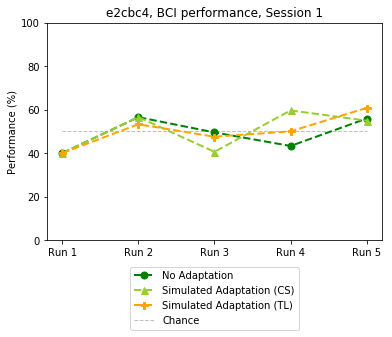

In [34]:
fig = plt.figure()
if subject_group == 1:
    
    plt.plot(orig_scores, color='green', marker='o', markersize=7,
             linestyle='dashed', linewidth=2)
    plt.plot(sim_scores, color='yellowgreen', marker='^', markersize=7,
             linestyle='dashed', linewidth=2)
    plt.plot(sim_TL_scores, color='orange', marker='P', markersize=7,
             linestyle='dashed', linewidth=2)
    plt.xticks([0, 1, 2, 3, 4],['Run 1','Run 2','Run 3','Run 4','Run 5'])
    plt.ylabel('Performance (%)')
    plt.hlines(y=50, xmin=0, xmax=4, color='gray', linestyles='dashed',
               linewidth=1, alpha=0.5)
    plt.ylim([0, 100])
    plt.title(subjID + ', BCI performance, Session ' + str(session_number))
    lgd = plt.legend(['No Adaptation','Simulated Adaptation (CS)','Simulated Adaptation (TL)','Chance'],
              loc='upper center', bbox_to_anchor=(0.5, -0.10))
    
elif subject_group == 2:
    plt.plot(sim_scores, color='green', marker='o', markersize=7,
             linestyle='dashed', linewidth=2)
    plt.plot(orig_scores, color='yellowgreen', marker='^', markersize=7,
             linestyle='dashed', linewidth=2)
    plt.plot(sim_TL_scores, color='orange', marker='P', markersize=7,
             linestyle='dashed', linewidth=2)
    plt.xticks([0, 1, 2, 3, 4],['Run 1','Run 2','Run 3','Run 4','Run 5'])
    plt.ylabel('Performance (%)')
    plt.hlines(y=50, xmin=0, xmax=4, color='gray', linestyles='dashed',
               linewidth=1, alpha=0.5)
    plt.ylim([0, 100])
    plt.title(subjID + ', BCI performance, Session ' + str(session_number))
    lgd = plt.legend(['Simulated No Adaptation','Co-Adaptation (CS)','Simulated Adaptation (TL)','Chance'],
              loc='upper center', bbox_to_anchor=(0.5, -0.10))

plt.show()
fig.savefig('Figures/' + subjID + '/' + model_type + '/' + subjID + '_Performance_Session-' + str(session_number) + '.png',
            bbox_extra_artists=(lgd,), bbox_inches='tight')

### Plot left vs right movements
Sometimes the movement is heavily biased towards one direction. Let's plot how often the box moves to the correct direction for each possible direction (left and right).

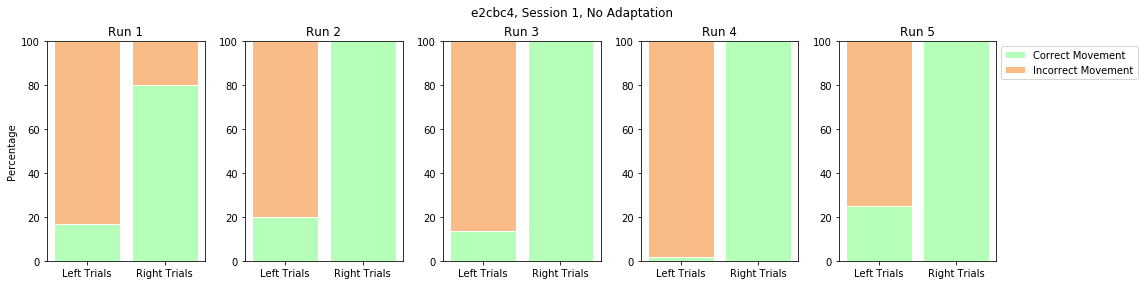

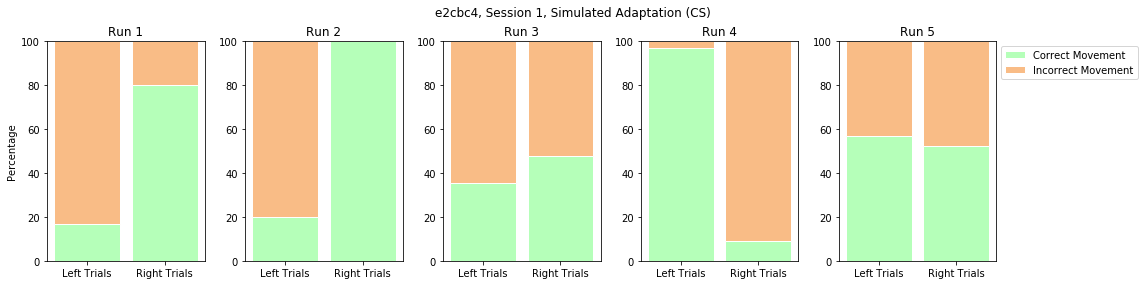

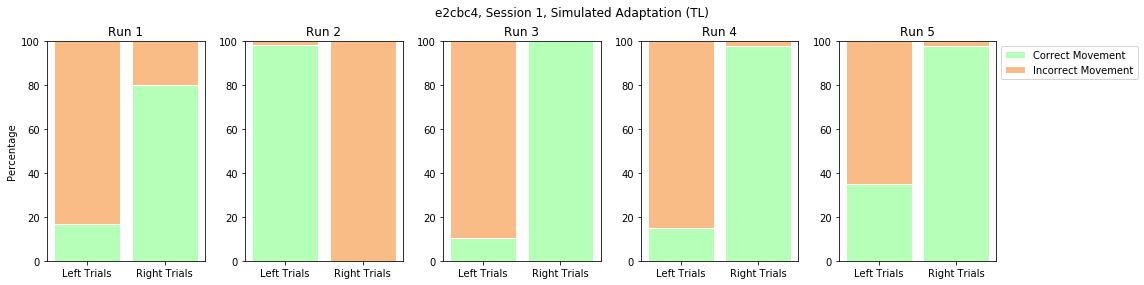

In [35]:
# Set adaptation type
adaptation_type = 'No Adaptation'

for adaptation_type in ['No Adaptation','Adaptation (CS)','Simulated Adaptation (TL)']:
    fig = plt.figure(figsize=(16,4))
    for runOfInt in range(1,5+1):
        # Calculate
        if subject_group == 1:
            if adaptation_type == 'No Adaptation':
                actual = clf_orig_all[runOfInt].predict(X_orig_all[runOfInt])
                TL = y_orig_all[runOfInt] # true labels
            elif adaptation_type == 'Adaptation (CS)':
                actual = clf_sim_all[runOfInt].predict(X_sim_all[runOfInt])
                TL = y_sim_all[runOfInt] # true labels
            elif adaptation_type == 'Simulated Adaptation (TL)':
                actual = clf_sim_TL_all[runOfInt].predict(X_sim_TL_all[runOfInt])
                TL = y_sim_TL_all[runOfInt] # true labels
        elif subject_group == 2:
            if adaptation_type == 'No Adaptation':
                actual = clf_sim_all[runOfInt].predict(X_sim_all[runOfInt])
                TL = y_sim_all[runOfInt] # true labels
            elif adaptation_type == 'Adaptation (CS)':
                actual = clf_orig_all[runOfInt].predict(X_orig_all[runOfInt])
                TL = y_orig_all[runOfInt] # true labels
            elif adaptation_type == 'Simulated Adaptation (TL)':
                actual = clf_sim_TL_all[runOfInt].predict(X_sim_TL_all[runOfInt])
                TL = y_sim_TL_all[runOfInt] # true labels
        trials_left = np.where(TL==0)[0]
        trials_right = np.where(TL==1)[0]
        left_correct = len(np.where(actual[trials_left]==0)[0])/len(actual[trials_left])*100
        left_wrong = 100 - left_correct
        right_correct = len(np.where(actual[trials_right]==1)[0])/len(actual[trials_right])*100
        right_wrong = 100 - right_correct

        # Organize data for bar plotting
        r = [0,1]
        raw_data = {'correctBars': [left_correct, right_correct], 'wrongBars': [left_wrong, right_wrong]}
        df = pd.DataFrame(raw_data)

        # From raw value to percentage
        correctBars = df['correctBars']
        wrongBars = df['wrongBars']

        # plot
        barWidth = 0.85
        names = ('Left Trials','Right Trials')
        plt.subplot(150+runOfInt)

        # Create green Bars
        plt.bar(r, correctBars, color='#b5ffb9', edgecolor='white', width=barWidth)
        # Create orange Bars
        plt.bar(r, wrongBars, bottom=correctBars, color='#f9bc86', edgecolor='white', width=barWidth)

        # Custom x axis
        plt.xticks(r, names)
        plt.ylim([0,100])
        if runOfInt == 1:
            plt.ylabel('Percentage')
        plt.title('Run ' + str(runOfInt))

    # Add a legend
    lgd = plt.legend(['Correct Movement','Incorrect Movement'], loc='upper left', bbox_to_anchor=(1,1), ncol=1)

    # Add super title
    if subject_group == 1:
        if adaptation_type == 'No Adaptation':
            fig.suptitle(subjID + ', Session ' + str(session_number) + ', No Adaptation')
        elif adaptation_type == 'Adaptation (CS)':
            fig.suptitle(subjID + ', Session ' + str(session_number) + ', Simulated Adaptation (CS)')
        elif adaptation_type == 'Simulated Adaptation (TL)':
            fig.suptitle(subjID + ', Session ' + str(session_number) + ', Simulated Adaptation (TL)')
    elif subject_group == 2:
        if adaptation_type == 'No Adaptation':
            fig.suptitle(subjID + ', Session ' + str(session_number) + ', Simulated No Adaptation')
        elif adaptation_type == 'Adaptation (CS)':
            fig.suptitle(subjID + ', Session ' + str(session_number) + ', Co-Adaptation (CS)')
        elif adaptation_type == 'Simulated Adaptation (TL)':
            fig.suptitle(subjID + ', Session ' + str(session_number) + ', Simulated Adaptation (TL)')
    fig.tight_layout()
    fig.subplots_adjust(top=0.86)

    # Show graphic
    plt.show()
    fig.savefig('Figures/' + subjID + '/' + model_type + '/' + subjID + '_LR_Session-' + str(session_number)
                + '_' + adaptation_type + '.png', bbox_extra_artists=(lgd,))